In [ ]:
!pip install tensorflow
!pip install keras

In [ ]:
import tensorflow as tf
import numpy as np
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten, Lambda
from keras.utils.np_utils import to_categorical
import VariantCalling as vc
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# VC Parameter
nb_alignment = 1000
nb_coverage = 100
prob_alignment = 0.01
prob_sequencing = 0.01
nb_channel = 2

# NN Parameters
img_row = nb_coverage + 1
img_col = 178
nb_epoch = 100
batch_size = 64
nb_filters = 48
nb_conv = 5
nb_pool = 5

In [ ]:
"""
This section to test ratio_gen, which is wrapper for alignments
"""
dg = vc.VariantCallingData()
alignments_raw, prob_lists = dg.simulate_clones(nb_alignment,nb_coverage,0.01,0.01)
prob_lists = (np.array(prob_lists)*100).tolist()


Progress:  0.0% completed. 	Computing alignment 0 of 1000
Progress:  5.0% completed. 	Computing alignment 50 of 1000
Progress:  10.0% completed. 	Computing alignment 100 of 1000
Progress:  15.0% completed. 	Computing alignment 150 of 1000
Progress:  20.0% completed. 	Computing alignment 200 of 1000
Progress:  25.0% completed. 	Computing alignment 250 of 1000
Progress:  30.0% completed. 	Computing alignment 300 of 1000
Progress:  35.0% completed. 	Computing alignment 350 of 1000
Progress:  40.0% completed. 	Computing alignment 400 of 1000
Progress:  45.0% completed. 	Computing alignment 450 of 1000
Progress:  50.0% completed. 	Computing alignment 500 of 1000
Progress:  55.0% completed. 	Computing alignment 550 of 1000
Progress:  60.0% completed. 	Computing alignment 600 of 1000
Progress:  65.0% completed. 	Computing alignment 650 of 1000
Progress:  70.0% completed. 	Computing alignment 700 of 1000
Progress:  75.0% completed. 	Computing alignment 750 of 1000
Progress:  80.0% completed. 	

In [ ]:
alignments = [dg._array_dup(i,nb_coverage+1) for i in alignments_raw]
alignments = dg.char_to_int(alignments)

In [ ]:
rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
idxs = np.arange(alignments.shape[0])

rng.shuffle(idxs)

split_idx = int(alignments.shape[0]*0.8)
train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
#train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]

In [ ]:
train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)

train_alignments = train_alignments.astype('float32')
valid_alignments = valid_alignments.astype('float32')

train_alignments /= 3
valid_alignments /= 3


In [ ]:
model = Sequential()
model.add(Conv2D(nb_filters, nb_conv, nb_conv))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool)))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Flatten())
model.add(Dense(32))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Dropout(0.1))
model.add(Activation('relu'))
#model.add(Dense(24))
#model.add(Dropout(0.2))
#model.add(Activation('relu'))
model.add(Dense(3))
model.add(Activation('softmax'))
model.add(Lambda(lambda x: x * 100))
model.compile(metrics=['mse'],loss='categorical_crossentropy',optimizer='adam')

In [ ]:
trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists))

Epoch 1/100
13/13 [==============================] - 5s 92ms/step - loss: 109.8758 - mse: 316.4955 - val_loss: 109.8532 - val_mse: 334.1810
Epoch 2/100
13/13 [==============================] - 1s 61ms/step - loss: 109.8633 - mse: 316.2160 - val_loss: 109.8307 - val_mse: 333.6934
Epoch 3/100
13/13 [==============================] - 1s 65ms/step - loss: 109.8567 - mse: 316.0654 - val_loss: 109.7933 - val_mse: 332.8454
Epoch 4/100
13/13 [==============================] - 1s 64ms/step - loss: 109.7453 - mse: 313.5656 - val_loss: 109.6797 - val_mse: 330.2430
Epoch 5/100
13/13 [==============================] - 1s 65ms/step - loss: 109.1135 - mse: 299.2826 - val_loss: 107.5359 - val_mse: 281.4323
Epoch 6/100
13/13 [==============================] - 1s 59ms/step - loss: 106.1070 - mse: 232.1370 - val_loss: 103.6564 - val_mse: 200.7109
Epoch 7/100
13/13 [==============================] - 1s 56ms/step - loss: 104.4810 - mse: 197.7535 - val_loss: 102.8750 - val_mse: 181.7217
Epoch 8/100
13/13 [=

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 35, 48)        2448      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 7, 48)         0         
 )                                                               
                                                                 
 activation (Activation)     (None, 4, 7, 48)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 2, 48)          57648     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 48)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 1, 1, 48)          0

In [ ]:
for i in range(0,4):
    dg = vc.VariantCallingData()
    alignments_raw, prob_lists = dg.simulate_clones(nb_alignment,nb_coverage,0.01,0.01)
    prob_lists = (np.array(prob_lists)*100).tolist()
    alignments = [dg._array_dup(i,nb_coverage+1) for i in alignments_raw]
    alignments = dg.char_to_int(alignments)
    rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
    idxs = np.arange(alignments.shape[0])

    rng.shuffle(idxs)

    split_idx = int(alignments.shape[0]*0.8)
    train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
    train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
    #train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
    train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
    valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)

    train_alignments = train_alignments.astype('float32')
    valid_alignments = valid_alignments.astype('float32')

    train_alignments /= 3
    valid_alignments /= 3
    trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists))
    model.summary()

Progress:  0.0% completed. 	Computing alignment 0 of 1000
Progress:  5.0% completed. 	Computing alignment 50 of 1000
Progress:  10.0% completed. 	Computing alignment 100 of 1000
Progress:  15.0% completed. 	Computing alignment 150 of 1000
Progress:  20.0% completed. 	Computing alignment 200 of 1000
Progress:  25.0% completed. 	Computing alignment 250 of 1000
Progress:  30.0% completed. 	Computing alignment 300 of 1000
Progress:  35.0% completed. 	Computing alignment 350 of 1000
Progress:  40.0% completed. 	Computing alignment 400 of 1000
Progress:  45.0% completed. 	Computing alignment 450 of 1000
Progress:  50.0% completed. 	Computing alignment 500 of 1000
Progress:  55.0% completed. 	Computing alignment 550 of 1000
Progress:  60.0% completed. 	Computing alignment 600 of 1000
Progress:  65.0% completed. 	Computing alignment 650 of 1000
Progress:  70.0% completed. 	Computing alignment 700 of 1000
Progress:  75.0% completed. 	Computing alignment 750 of 1000
Progress:  80.0% completed. 	

In [ ]:
with open('output.csv', 'w') as file:
    predict_array = model.predict(valid_alignments).tolist()
    for i in range(0, len(valid_prob_lists)):
        file.write("\nPredicted\n")
        file.write(str(predict_array[i]))
        file.write("\nActual\n")
        file.write(str(valid_prob_lists[i]))

7/7 [==============================] - 0s 11ms/step


       col_3D7    col_7G8    col_DD2
0    42.019634   7.518555  50.461811
1    21.790583  35.313885  42.895527
2    43.265820  29.681408  27.052773
3    42.377235  15.274094  42.348663
4    46.735546  29.534494  23.729961
..         ...        ...        ...
195  33.751766  15.003042  51.245193
196  21.067234  10.248728  68.684036
197  68.882973  25.222191   5.894832
198  47.721786  28.813076  23.465130
199  29.485283  46.731628  23.783094

[200 rows x 3 columns]
       col_3D7    col_7G8    col_DD2
0    41.450520   8.324283  50.225197
1    18.957824  34.798688  46.243488
2    44.649397  30.583317  24.767286
3    42.931787  14.632529  42.435684
4    48.878151  28.926566  22.195283
..         ...        ...        ...
195  33.592707  17.967659  48.439634
196  24.422828   7.300508  68.276664
197  70.024748  26.325693   3.649559
198  49.059447  30.568727  20.371825
199  23.675255  56.025815  20.298930

[200 rows x 3 columns]


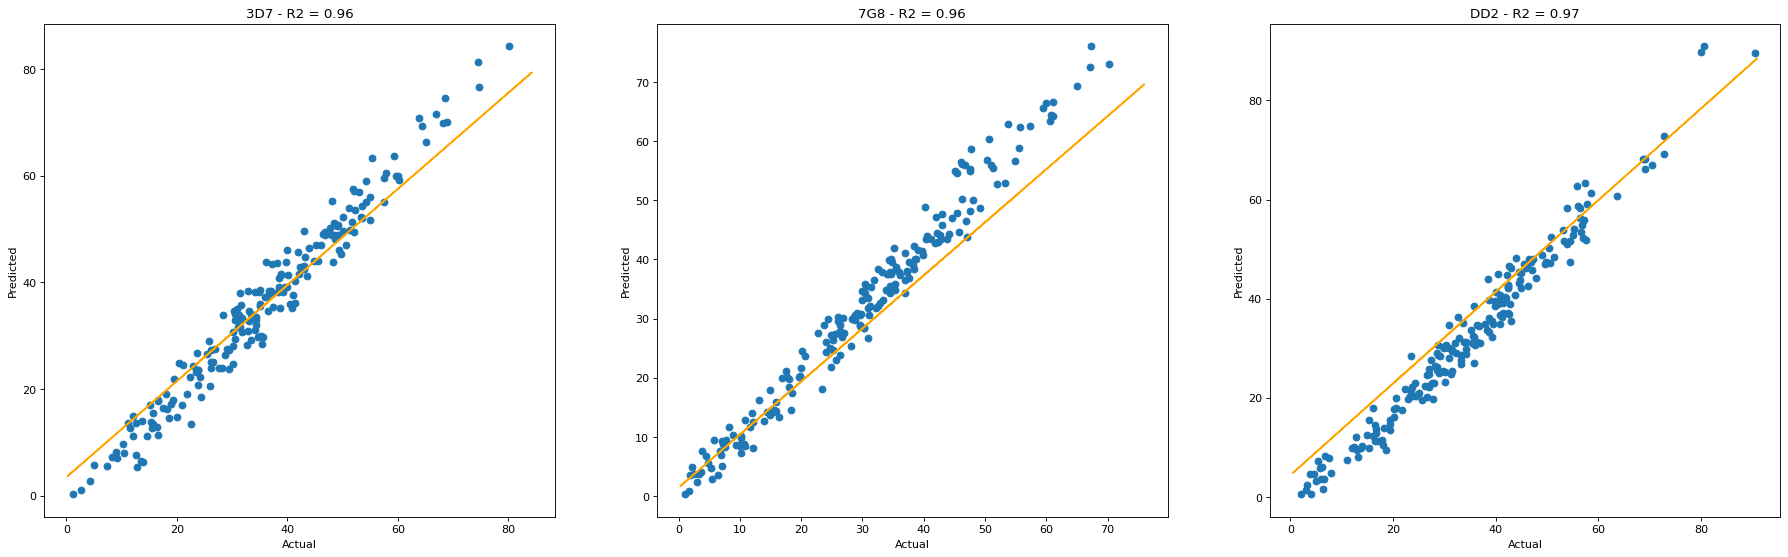

In [ ]:
# Data visualisation and performance evaluation
import pandas as pd
from scipy.stats import linregress
from sklearn.metrics import r2_score

df_predict = pd.DataFrame(predict_array)
df_actual = pd.DataFrame(valid_prob_lists)

# Setup the headers
df_predict.columns = ["col_3D7", "col_7G8", "col_DD2"]
df_actual.columns = ["col_3D7", "col_7G8", "col_DD2"]

print(df_predict)
print(df_actual)

plt.figure(figsize=(28, 8), dpi=80)
plt.subplot(1, 3, 1)
r2 = r2_score(df_actual.col_3D7, df_predict.col_3D7)
(m_1, b_1) = np.polyfit(df_actual.col_3D7, df_predict.col_3D7, 1)
yp_1 = np.polyval([m_1, b_1], df_actual.col_3D7)
plt.plot(df_actual.col_3D7, yp_1, color='orange')
plt.title('3D7 - R2 = {r2_score}'.format(r2_score=round(r2,2)))
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.scatter(df_predict.col_3D7, df_actual.col_3D7)

plt.subplot(1, 3, 2)
r2 = r2_score(df_actual.col_7G8, df_predict.col_7G8)
(m_2, b_2) = np.polyfit(df_actual.col_7G8, df_predict.col_7G8, 1)
yp_2 = np.polyval([m_2, b_2], df_actual.col_7G8)
plt.plot(df_actual.col_7G8, yp_2, color='orange')
plt.title('7G8 - R2 = {r2_score}'.format(r2_score=round(r2,2)))
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.scatter(df_predict.col_7G8, df_actual.col_7G8)


plt.subplot(1, 3, 3)
(m_3, b_3) = np.polyfit(df_actual.col_DD2, df_predict.col_DD2, 1)
yp_3 = np.polyval([m_3, b_3], df_actual.col_DD2)
r2 = r2_score(yp_3, df_predict.col_DD2)
plt.plot(df_actual.col_DD2, yp_3, color='orange')
plt.title('DD2 - R2 = {r2_score}'.format(r2_score=round(r2,2)))
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.scatter(df_predict.col_DD2, df_actual.col_DD2)

# Here we start evaluating the multi-channel performance using the same network architecture

In [ ]:
# Update the number of channels
nb_channel = 4

In [ ]:
"""
This section to test ratio_gen, which is wrapper for alignments
"""
dg = vc.VariantCallingData()
alignments_raw, prob_lists = dg.simulate_clones(nb_alignment,nb_coverage,prob_alignment,prob_sequencing)
prob_lists = (np.array(prob_lists)*100).tolist()


Progress:  0.0% completed. 	Computing alignment 0 of 1000
Progress:  5.0% completed. 	Computing alignment 50 of 1000
Progress:  10.0% completed. 	Computing alignment 100 of 1000
Progress:  15.0% completed. 	Computing alignment 150 of 1000
Progress:  20.0% completed. 	Computing alignment 200 of 1000
Progress:  25.0% completed. 	Computing alignment 250 of 1000
Progress:  30.0% completed. 	Computing alignment 300 of 1000
Progress:  35.0% completed. 	Computing alignment 350 of 1000
Progress:  40.0% completed. 	Computing alignment 400 of 1000
Progress:  45.0% completed. 	Computing alignment 450 of 1000
Progress:  50.0% completed. 	Computing alignment 500 of 1000
Progress:  55.0% completed. 	Computing alignment 550 of 1000
Progress:  60.0% completed. 	Computing alignment 600 of 1000
Progress:  65.0% completed. 	Computing alignment 650 of 1000
Progress:  70.0% completed. 	Computing alignment 700 of 1000
Progress:  75.0% completed. 	Computing alignment 750 of 1000
Progress:  80.0% completed. 	

In [ ]:
# Here we evaluate the multi-channel performance using the same network architecture
alignments = [dg._array_dup_all(i,nb_coverage+1) for i in alignments_raw]
alignments = dg.char_to_int(alignments)

In [ ]:
rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
idxs = np.arange(alignments.shape[0])

rng.shuffle(idxs)

split_idx = int(alignments.shape[0]*0.8)
train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]

In [ ]:
train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)

train_alignments = train_alignments.astype('float32')
valid_alignments = valid_alignments.astype('float32')

train_alignments /= 3
valid_alignments /= 3


In [ ]:
model = Sequential()
model.add(Conv2D(nb_filters, nb_conv, nb_conv))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool)))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Flatten())
model.add(Dense(32))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Dropout(0.1))
model.add(Activation('relu'))
#model.add(Dense(24))
#model.add(Dropout(0.2))
#model.add(Activation('relu'))
model.add(Dense(3))
model.add(Activation('softmax'))
model.add(Lambda(lambda x: x * 100))
model.compile(metrics=['mse'],loss='categorical_crossentropy',optimizer='adam')

In [ ]:
trained_model_fc = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists))

Epoch 1/100
13/13 [==============================] - 3s 103ms/step - loss: 109.8527 - mse: 335.8555 - val_loss: 109.9439 - val_mse: 326.7091
Epoch 2/100
13/13 [==============================] - 1s 108ms/step - loss: 109.8442 - mse: 335.6623 - val_loss: 109.8898 - val_mse: 325.4883
Epoch 3/100
13/13 [==============================] - 2s 130ms/step - loss: 109.8502 - mse: 335.8051 - val_loss: 109.9144 - val_mse: 326.0375
Epoch 4/100
13/13 [==============================] - 1s 96ms/step - loss: 109.8290 - mse: 335.3169 - val_loss: 109.9333 - val_mse: 326.4704
Epoch 5/100
13/13 [==============================] - 1s 71ms/step - loss: 109.8248 - mse: 335.2337 - val_loss: 109.9227 - val_mse: 326.2303
Epoch 6/100
13/13 [==============================] - 1s 71ms/step - loss: 109.8413 - mse: 335.5843 - val_loss: 109.9225 - val_mse: 326.2105
Epoch 7/100
13/13 [==============================] - 1s 72ms/step - loss: 109.7930 - mse: 334.5194 - val_loss: 109.8742 - val_mse: 325.1378
Epoch 8/100
13/13

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 20, 35, 48)        4848      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 7, 48)         0         
 2D)                                                             
                                                                 
 activation_6 (Activation)   (None, 4, 7, 48)          0         
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 2, 48)          57648     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1, 1, 48)         0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 1, 1, 48)         

In [ ]:
for i in range(0,4):
    """
    This section to test ratio_gen, which is wrapper for alignments
    """
    dg = vc.VariantCallingData()
    alignments_raw, prob_lists = dg.simulate_clones(nb_alignment,nb_coverage,prob_alignment,prob_sequencing)
    prob_lists = (np.array(prob_lists)*100).tolist()


    # Here we evaluate the multi-channel performance using the same network architecture
    alignments = [dg._array_dup_all(i,nb_coverage+1) for i in alignments_raw]
    alignments = dg.char_to_int(alignments)

    rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
    idxs = np.arange(alignments.shape[0])

    rng.shuffle(idxs)

    split_idx = int(alignments.shape[0]*0.8)
    train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
    train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]

    train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
    valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)

    train_alignments = train_alignments.astype('float32')
    valid_alignments = valid_alignments.astype('float32')

    train_alignments /= 3
    valid_alignments /= 3

    trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists))
    model.summary()

Progress:  0.0% completed. 	Computing alignment 0 of 1000
Progress:  5.0% completed. 	Computing alignment 50 of 1000
Progress:  10.0% completed. 	Computing alignment 100 of 1000
Progress:  15.0% completed. 	Computing alignment 150 of 1000
Progress:  20.0% completed. 	Computing alignment 200 of 1000
Progress:  25.0% completed. 	Computing alignment 250 of 1000
Progress:  30.0% completed. 	Computing alignment 300 of 1000
Progress:  35.0% completed. 	Computing alignment 350 of 1000
Progress:  40.0% completed. 	Computing alignment 400 of 1000
Progress:  45.0% completed. 	Computing alignment 450 of 1000
Progress:  50.0% completed. 	Computing alignment 500 of 1000
Progress:  55.0% completed. 	Computing alignment 550 of 1000
Progress:  60.0% completed. 	Computing alignment 600 of 1000
Progress:  65.0% completed. 	Computing alignment 650 of 1000
Progress:  70.0% completed. 	Computing alignment 700 of 1000
Progress:  75.0% completed. 	Computing alignment 750 of 1000
Progress:  80.0% completed. 	

In [ ]:
with open('output_fc.csv', 'w') as file:
    predict_array = model.predict(valid_alignments).tolist()
    for i in range(0, len(valid_prob_lists)):
        file.write("\nPredicted\n")
        file.write(str(predict_array[i]))
        file.write("\nActual\n")
        file.write(str(valid_prob_lists[i]))

7/7 [==============================] - 0s 15ms/step


       col_3D7    col_7G8    col_DD2
0    57.390285  14.263720  28.345997
1     4.640920  21.667572  73.691513
2    33.816990  32.287178  33.895828
3    39.332321  30.688793  29.978889
4    59.277916  19.839869  20.882212
..         ...        ...        ...
195  11.343767  35.786221  52.870010
196  15.138444  79.358414   5.503149
197  46.223389  45.538368   8.238252
198  14.879079  26.238239  58.882683
199  27.162781  33.893032  38.944168

[200 rows x 3 columns]
       col_3D7    col_7G8    col_DD2
0    58.703743  13.642103  27.654154
1     2.556814  26.494886  70.948300
2    25.764908  34.802487  39.432605
3    39.643734  29.845972  30.510294
4    60.469785  19.080401  20.449814
..         ...        ...        ...
195   8.771777  35.259812  55.968411
196  10.704948  87.926234   1.368817
197  47.360524  46.052642   6.586833
198  13.458263  28.111420  58.430317
199  23.421361  36.318320  40.260319

[200 rows x 3 columns]


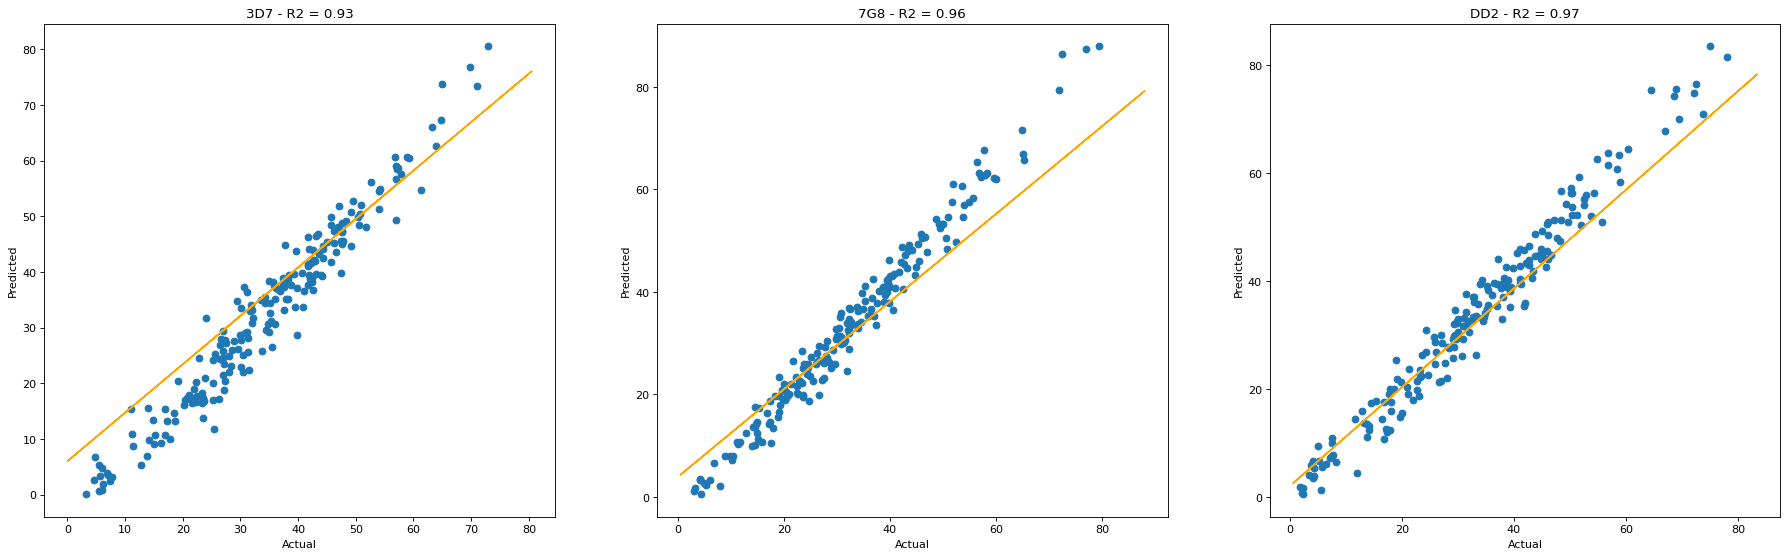

In [ ]:
df_predict_fc = pd.DataFrame(predict_array)
df_actual_fc = pd.DataFrame(valid_prob_lists)

# Setup the headers
df_predict_fc.columns = ["col_3D7", "col_7G8", "col_DD2"]
df_actual_fc.columns = ["col_3D7", "col_7G8", "col_DD2"]

print(df_predict_fc)
print(df_actual_fc)

plt.figure(figsize=(28, 8), dpi=80)
plt.subplot(1, 3, 1)
r2 = r2_score(df_actual_fc.col_3D7, df_predict_fc.col_3D7)
(m_1, b_1) = np.polyfit(df_actual_fc.col_3D7, df_predict_fc.col_3D7, 1)
yp_1 = np.polyval([m_1, b_1], df_actual_fc.col_3D7)
plt.plot(df_actual_fc.col_3D7, yp_1, color='orange')
plt.title('3D7 - R2 = {r2_score}'.format(r2_score=round(r2,2)))
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.scatter(df_predict_fc.col_3D7, df_actual_fc.col_3D7)

plt.subplot(1, 3, 2)
r2 = r2_score(df_actual_fc.col_7G8, df_predict_fc.col_7G8)
(m_2, b_2) = np.polyfit(df_actual_fc.col_7G8, df_predict_fc.col_7G8, 1)
yp_2 = np.polyval([m_2, b_2], df_actual_fc.col_7G8)
plt.plot(df_actual_fc.col_7G8, yp_2, color='orange')
plt.title('7G8 - R2 = {r2_score}'.format(r2_score=round(r2,2)))
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.scatter(df_predict_fc.col_7G8, df_actual_fc.col_7G8)


plt.subplot(1, 3, 3)
(m_3, b_3) = np.polyfit(df_actual_fc.col_DD2, df_predict_fc.col_DD2, 1)
yp_3 = np.polyval([m_3, b_3], df_actual_fc.col_DD2)
r2 = r2_score(yp_3, df_predict_fc.col_DD2)
plt.plot(df_actual_fc.col_DD2, yp_3, color='orange')
plt.title('DD2 - R2 = {r2_score}'.format(r2_score=round(r2,2)))
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.scatter(df_predict_fc.col_DD2, df_actual_fc.col_DD2)

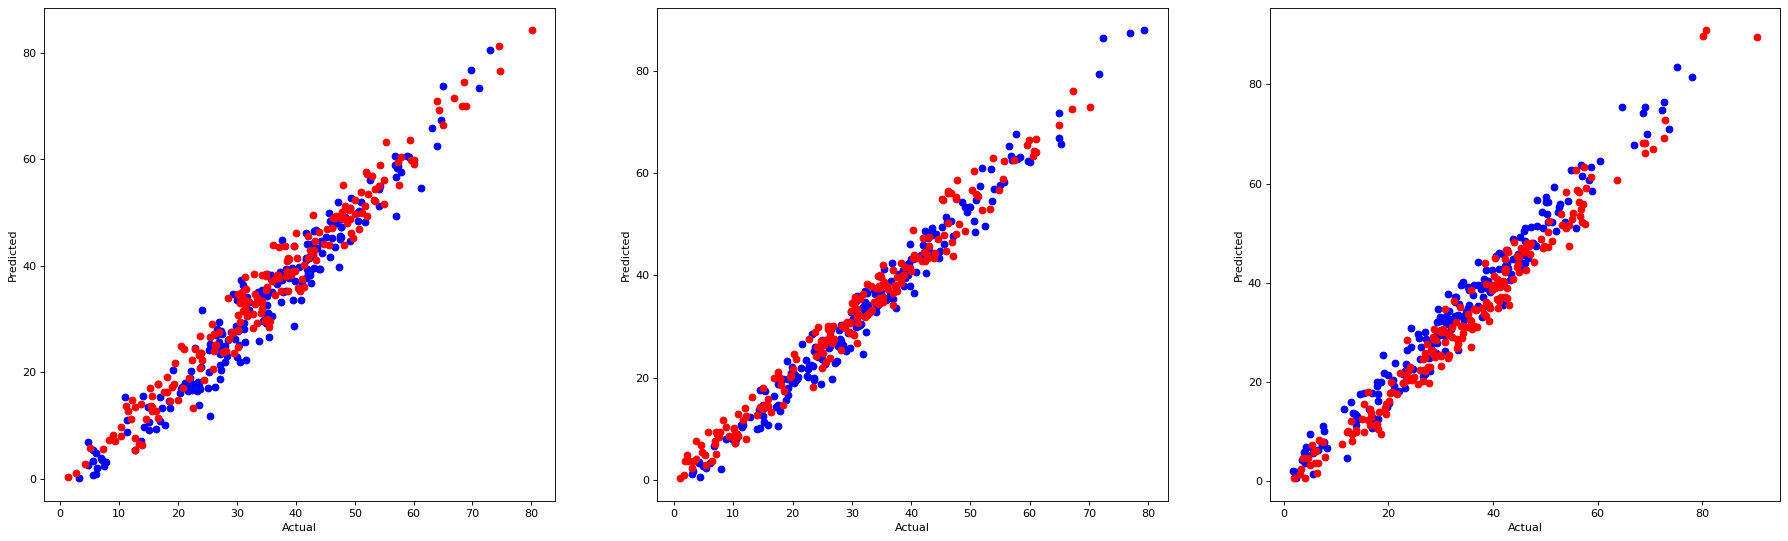

In [ ]:
plt.figure(figsize=(28, 8), dpi=80)
plt.subplot(1, 3, 1)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.scatter(df_predict_fc.col_3D7, df_actual_fc.col_3D7, color='blue')
plt.scatter(df_predict.col_3D7, df_actual.col_3D7, color='red')

plt.subplot(1, 3, 2)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.scatter(df_predict_fc.col_7G8, df_actual_fc.col_7G8, color='blue')
plt.scatter(df_predict.col_7G8, df_actual.col_7G8, color='red')

plt.subplot(1, 3, 3)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.scatter(df_predict_fc.col_DD2, df_actual_fc.col_DD2, color='blue')
plt.scatter(df_predict.col_DD2, df_actual.col_DD2, color='red')

# Here we try only 1 channel

In [ ]:
# Update the number of channels
nb_channel = 1

In [ ]:
"""
This section to test ratio_gen, which is wrapper for alignments
"""
dg = vc.VariantCallingData()
alignments_raw, prob_lists = dg.simulate_clones(nb_alignment,nb_coverage,prob_alignment,prob_sequencing)
prob_lists = (np.array(prob_lists)*100).tolist()


Progress:  0.0% completed. 	Computing alignment 0 of 1000
Progress:  5.0% completed. 	Computing alignment 50 of 1000
Progress:  10.0% completed. 	Computing alignment 100 of 1000
Progress:  15.0% completed. 	Computing alignment 150 of 1000
Progress:  20.0% completed. 	Computing alignment 200 of 1000
Progress:  25.0% completed. 	Computing alignment 250 of 1000
Progress:  30.0% completed. 	Computing alignment 300 of 1000
Progress:  35.0% completed. 	Computing alignment 350 of 1000
Progress:  40.0% completed. 	Computing alignment 400 of 1000
Progress:  45.0% completed. 	Computing alignment 450 of 1000
Progress:  50.0% completed. 	Computing alignment 500 of 1000
Progress:  55.0% completed. 	Computing alignment 550 of 1000
Progress:  60.0% completed. 	Computing alignment 600 of 1000
Progress:  65.0% completed. 	Computing alignment 650 of 1000
Progress:  70.0% completed. 	Computing alignment 700 of 1000
Progress:  75.0% completed. 	Computing alignment 750 of 1000
Progress:  80.0% completed. 	

In [ ]:
# Here we evaluate the multi-channel performance using the same network architecture
alignments = [np.array(i) for i in alignments_raw]
alignments = dg.char_to_int(alignments)

In [ ]:
rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
idxs = np.arange(alignments.shape[0])

rng.shuffle(idxs)

split_idx = int(alignments.shape[0]*0.8)
train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]

In [ ]:
train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)

train_alignments = train_alignments.astype('float32')
valid_alignments = valid_alignments.astype('float32')

train_alignments /= 3
valid_alignments /= 3


In [ ]:
model = Sequential()
model.add(Conv2D(nb_filters, nb_conv, nb_conv))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool)))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Flatten())
model.add(Dense(32))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Dropout(0.1))
model.add(Activation('relu'))
#model.add(Dense(24))
#model.add(Dropout(0.2))
#model.add(Activation('relu'))
model.add(Dense(3))
model.add(Activation('softmax'))
model.add(Lambda(lambda x: x * 100))
model.compile(metrics=['mse'],loss='categorical_crossentropy',optimizer='adam')

In [ ]:
trained_model_oc = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists))

Epoch 1/100
13/13 [==============================] - 3s 79ms/step - loss: 109.8704 - mse: 315.8941 - val_loss: 109.8567 - val_mse: 317.6939
Epoch 2/100
13/13 [==============================] - 1s 91ms/step - loss: 109.8716 - mse: 315.9225 - val_loss: 109.8862 - val_mse: 318.3511
Epoch 3/100
13/13 [==============================] - 2s 140ms/step - loss: 109.8700 - mse: 315.8860 - val_loss: 109.8498 - val_mse: 317.5400
Epoch 4/100
13/13 [==============================] - 1s 101ms/step - loss: 109.8176 - mse: 314.7162 - val_loss: 109.6593 - val_mse: 313.2818
Epoch 5/100
13/13 [==============================] - 1s 54ms/step - loss: 108.8957 - mse: 293.6959 - val_loss: 107.7387 - val_mse: 268.0031
Epoch 6/100
13/13 [==============================] - 1s 53ms/step - loss: 106.4630 - mse: 237.1569 - val_loss: 105.9694 - val_mse: 227.5067
Epoch 7/100
13/13 [==============================] - 1s 52ms/step - loss: 105.4599 - mse: 215.7973 - val_loss: 104.8412 - val_mse: 206.0114
Epoch 8/100
13/13 

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 20, 35, 48)        1248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 4, 7, 48)         0         
 2D)                                                             
                                                                 
 activation_12 (Activation)  (None, 4, 7, 48)          0         
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 2, 48)          57648     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 1, 1, 48)         0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 1, 1, 48)         

In [ ]:
for i in range(0,4):
    # Update the number of channels
    nb_channel = 1

    """
    This section to test ratio_gen, which is wrapper for alignments
    """
    dg = vc.VariantCallingData()
    alignments_raw, prob_lists = dg.simulate_clones(nb_alignment,nb_coverage,prob_alignment,prob_sequencing)
    prob_lists = (np.array(prob_lists)*100).tolist()


    # Here we evaluate the multi-channel performance using the same network architecture
    alignments = [np.array(i) for i in alignments_raw]
    alignments = dg.char_to_int(alignments)

    rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
    idxs = np.arange(alignments.shape[0])

    rng.shuffle(idxs)

    split_idx = int(alignments.shape[0]*0.8)
    train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
    train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]

    train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
    valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)

    train_alignments = train_alignments.astype('float32')
    valid_alignments = valid_alignments.astype('float32')

    train_alignments /= 3
    valid_alignments /= 3

    trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists))
    model.summary()

Progress:  0.0% completed. 	Computing alignment 0 of 1000
Progress:  5.0% completed. 	Computing alignment 50 of 1000
Progress:  10.0% completed. 	Computing alignment 100 of 1000
Progress:  15.0% completed. 	Computing alignment 150 of 1000
Progress:  20.0% completed. 	Computing alignment 200 of 1000
Progress:  25.0% completed. 	Computing alignment 250 of 1000
Progress:  30.0% completed. 	Computing alignment 300 of 1000
Progress:  35.0% completed. 	Computing alignment 350 of 1000
Progress:  40.0% completed. 	Computing alignment 400 of 1000
Progress:  45.0% completed. 	Computing alignment 450 of 1000
Progress:  50.0% completed. 	Computing alignment 500 of 1000
Progress:  55.0% completed. 	Computing alignment 550 of 1000
Progress:  60.0% completed. 	Computing alignment 600 of 1000
Progress:  65.0% completed. 	Computing alignment 650 of 1000
Progress:  70.0% completed. 	Computing alignment 700 of 1000
Progress:  75.0% completed. 	Computing alignment 750 of 1000
Progress:  80.0% completed. 	

In [ ]:
with open('output_fc.csv', 'w') as file:
    predict_array = model.predict(valid_alignments).tolist()
    for i in range(0, len(valid_prob_lists)):
        file.write("\nPredicted\n")
        file.write(str(predict_array[i]))
        file.write("\nActual\n")
        file.write(str(valid_prob_lists[i]))

7/7 [==============================] - 0s 8ms/step


       col_3D7    col_7G8    col_DD2
0    31.993046  32.194130  35.812820
1    25.238981  30.991312  43.769703
2    10.428728   6.667957  82.903305
3    16.492313  45.359867  38.147820
4    23.253834  60.071289  16.674870
..         ...        ...        ...
195  12.220448  18.463558  69.315994
196   9.820809  24.669336  65.509850
197   3.978588  12.145924  83.875488
198  38.158562  36.287205  25.554232
199  28.533295  34.645046  36.821644

[200 rows x 3 columns]
       col_3D7    col_7G8    col_DD2
0    28.317086  32.178105  39.504810
1    20.556336  30.874753  48.568911
2     6.634866   4.927112  88.438022
3    13.777364  46.589633  39.633004
4    24.547266  63.549471  11.903263
..         ...        ...        ...
195   9.957534  11.748625  78.293840
196   8.784534  17.273485  73.941981
197   1.547267   9.211528  89.241204
198  34.159313  40.070719  25.769968
199  22.775800  35.687403  41.536797

[200 rows x 3 columns]


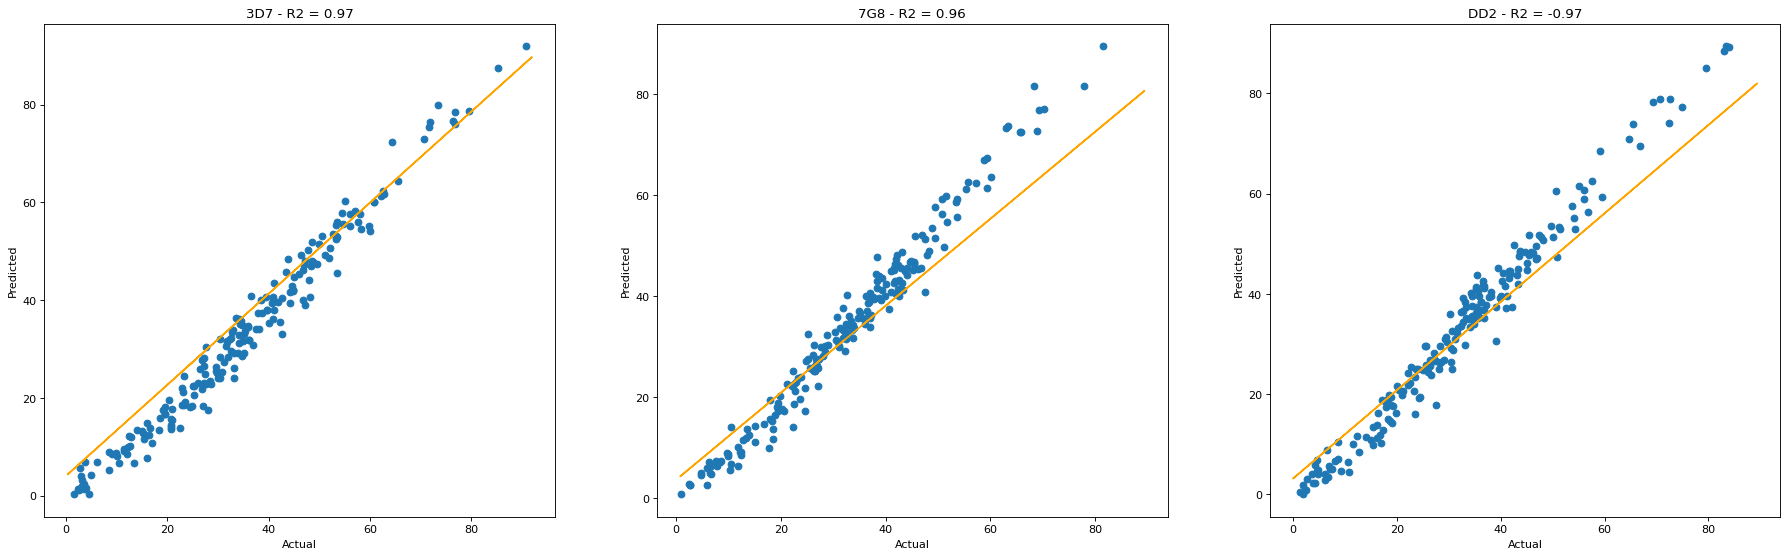

In [ ]:
df_predict_oc = pd.DataFrame(predict_array)
df_actual_oc = pd.DataFrame(valid_prob_lists)

# Setup the headers
df_predict_oc.columns = ["col_3D7", "col_7G8", "col_DD2"]
df_actual_oc.columns = ["col_3D7", "col_7G8", "col_DD2"]

print(df_predict_oc)
print(df_actual_oc)

plt.figure(figsize=(28, 8), dpi=80)
plt.subplot(1, 3, 1)
r2 = r2_score(df_actual_oc.col_3D7, df_predict_oc.col_3D7)
(m_1, b_1) = np.polyfit(df_actual_oc.col_3D7, df_predict_oc.col_3D7, 1)
yp_1 = np.polyval([m_1, b_1], df_actual_oc.col_3D7)
plt.plot(df_actual_oc.col_3D7, yp_1, color='orange')
plt.title('3D7 - R2 = {r2_score}'.format(r2_score=round(r2,2)))
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.scatter(df_predict_oc.col_3D7, df_actual_oc.col_3D7)

plt.subplot(1, 3, 2)
r2 = r2_score(df_actual_oc.col_7G8, df_predict_oc.col_7G8)
(m_2, b_2) = np.polyfit(df_actual_oc.col_7G8, df_predict_oc.col_7G8, 1)
yp_2 = np.polyval([m_2, b_2], df_actual_oc.col_7G8)
plt.plot(df_actual_oc.col_7G8, yp_2, color='orange')
plt.title('7G8 - R2 = {r2_score}'.format(r2_score=round(r2,2)))
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.scatter(df_predict_oc.col_7G8, df_actual_oc.col_7G8)


plt.subplot(1, 3, 3)
(m_3, b_3) = np.polyfit(df_actual_oc.col_DD2, df_predict_oc.col_DD2, 1)
yp_3 = np.polyval([m_3, b_3], df_actual_oc.col_DD2)
r2 = r2_score(yp_3, df_predict_fc.col_DD2)
plt.plot(df_actual_oc.col_DD2, yp_3, color='orange')
plt.title('DD2 - R2 = {r2_score}'.format(r2_score=round(r2,2)))
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.scatter(df_predict_oc.col_DD2, df_actual_oc.col_DD2)

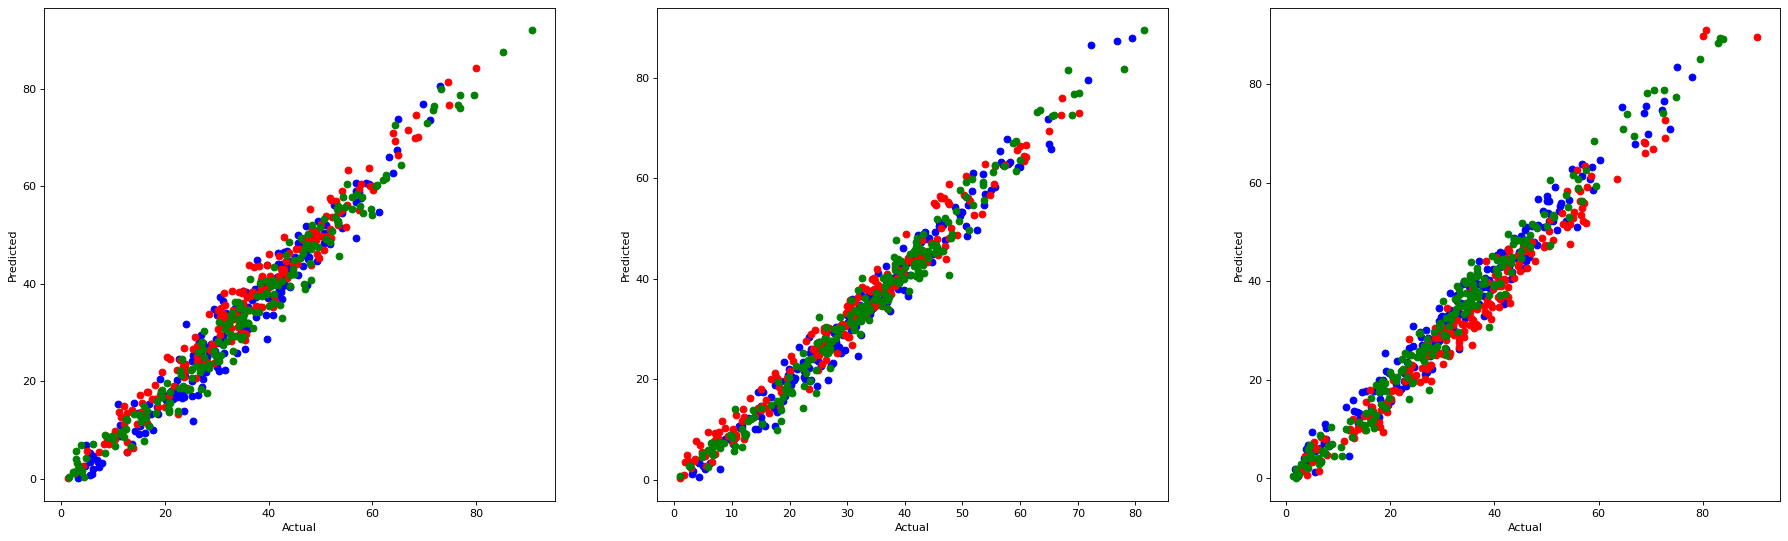

In [ ]:
plt.figure(figsize=(28, 8), dpi=80)
plt.subplot(1, 3, 1)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.scatter(df_predict_fc.col_3D7, df_actual_fc.col_3D7, color='blue')
plt.scatter(df_predict.col_3D7, df_actual.col_3D7, color='red')
plt.scatter(df_predict_oc.col_3D7, df_actual_oc.col_3D7, color='green')

plt.subplot(1, 3, 2)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.scatter(df_predict_fc.col_7G8, df_actual_fc.col_7G8, color='blue')
plt.scatter(df_predict.col_7G8, df_actual.col_7G8, color='red')
plt.scatter(df_predict_oc.col_7G8, df_actual_oc.col_7G8, color='green')

plt.subplot(1, 3, 3)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.scatter(df_predict_fc.col_DD2, df_actual_fc.col_DD2, color='blue')
plt.scatter(df_predict.col_DD2, df_actual.col_DD2, color='red')
plt.scatter(df_predict_oc.col_DD2, df_actual_oc.col_DD2, color='green')